In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from glob import glob
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import preprocess_input
from datetime import datetime
from tensorflow.keras.models import load_model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls '/content/drive/MyDrive/Knee Osteoarthritis Dataset with Severity Grading 3 class/'

 augmented_val_set
 auto_test
'best_model_accuracy_graph_resnet 2023-08-31 17:14:59.png'
'best_model_loss_graph_resnet 2023-08-31 17:14:59.png'
'best_model_resnet 1st stage 2023-08-31 14:14:54.h5'
'best_model_resnet 2nd stage 2023-08-31 15:38:17.h5'
 results.csv
 test
 train
 val


In [ ]:
model = load_model("/content/drive/MyDrive/Knee Osteoarthritis Dataset with Severity Grading 3 class/best_model_resnet 2nd stage 2023-08-31 15:38:17.h5")
print("Loaded model from disk")

Loaded model from disk


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dense_1 (Dense)             (None, 3)                 1539      
                                                                 
Total params: 24,638,339
Trainable params: 24,585,219
Non-trainable params: 53,120
_________________________________________________________________


In [ ]:
val_path = '/content/drive/MyDrive/Knee Osteoarthritis Dataset with Severity Grading 3 class/test'

In [ ]:
val_datagen = ImageDataGenerator(
    # preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

In [ ]:
start = datetime.now()

val_set = val_datagen.flow_from_directory(val_path,
                                            target_size = (224, 224),
                                            color_mode="rgb",
                                            batch_size = 1,
                                          shuffle=True,
                                            class_mode = 'categorical',
                                          # save_to_dir= "/content/drive/MyDrive/Knee Osteoarthritis Dataset with Severity Grading 3 class/augmented_val_set",
                                          # save_format="png",
                                          seed=42)

history =model.evaluate_generator(generator= val_set)

duration = datetime.now() - start
print("Training completed in time: ", duration)

Found 1656 images belonging to 3 classes.


<ipython-input-8-3a487e8d33f9>:13: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  history =model.evaluate_generator(generator= val_set)


Training completed in time:  0:08:27.974003


In [ ]:
history

[0.11448011547327042, 0.9359903335571289]

In [ ]:
test_datagen = ImageDataGenerator(
    # preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

In [ ]:
test_path = '/content/drive/MyDrive/Knee Osteoarthritis Dataset with Severity Grading 3 class/val'

In [ ]:
test_set = test_datagen.flow_from_directory(test_path,
                                            target_size=(224,224),
                                            color_mode="rgb",
                                            batch_size=1,
                                            shuffle=False,
                                            class_mode=None,
                                            seed = 42)

Found 826 images belonging to 3 classes.


In [ ]:
length=len(test_set)
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]
test_steps=int(length/test_batch_size)
msg='{0:70s} for test generator'.format(' ')
print(msg, '\r', end='') # prints over on the same line

In [ ]:
test_batch_size

59

In [ ]:
test_steps

14

826/826 [==============================] - 272s 329ms/step
there were 65 errors in 826 tests for an accuracy of  92.13


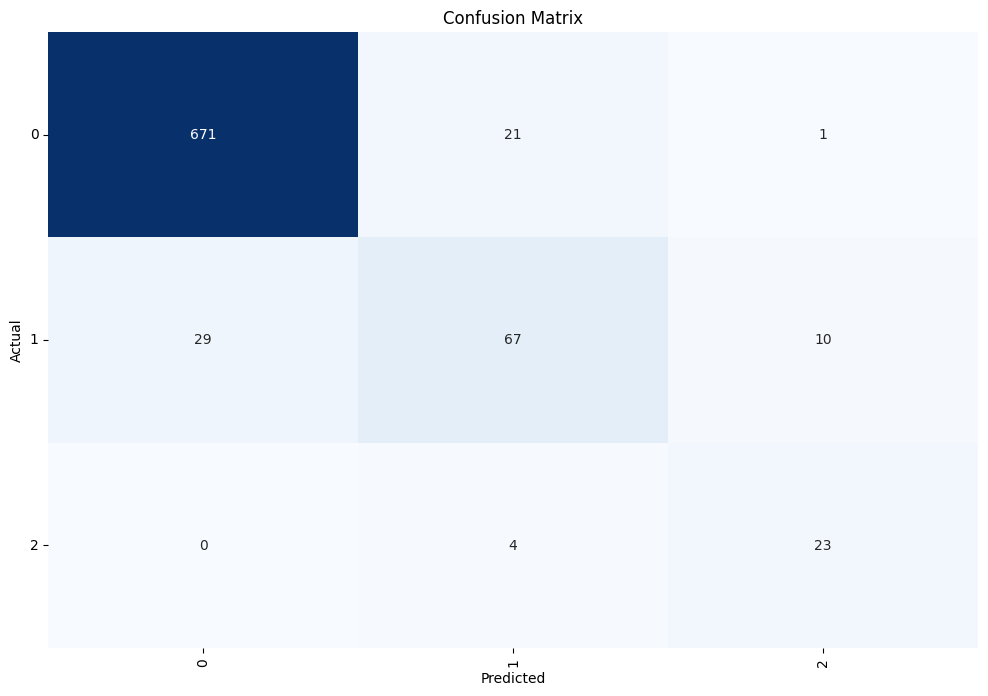

Classification Report:
----------------------
               precision    recall  f1-score   support

           0     0.9586    0.9683    0.9634       693
           1     0.7283    0.6321    0.6768       106
           2     0.6765    0.8519    0.7541        27

    accuracy                         0.9213       826
   macro avg     0.7878    0.8174    0.7981       826
weighted avg     0.9198    0.9213    0.9198       826



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

def predictor(test_set, test_steps):
    y_pred= []
    y_true=test_set.labels
    classes=list(test_set.class_indices.keys())
    class_count=len(classes)
    errors=0
    preds=model.predict(test_set, verbose=1)
    tests=len(preds)
    for i, p in enumerate(preds):
        pred_index=np.argmax(p)
        true_index=test_set.labels[i]  # labels are integer values
        if pred_index != true_index: # a misclassification has occurred
            errors=errors + 1
            file=test_set.filenames[i]
        y_pred.append(pred_index)

    acc=( 1-errors/tests) * 100
    print(f'there were {errors} errors in {tests} tests for an accuracy of {acc:6.2f}')
    ypred=np.array(y_pred)
    ytrue=np.array(y_true)
    if class_count <=30:
        cm = confusion_matrix(ytrue, ypred )
        # plot the confusion matrix
        plt.figure(figsize=(12, 8))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
        plt.xticks(np.arange(class_count)+.5, classes, rotation=90)
        plt.yticks(np.arange(class_count)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
    clr = classification_report(y_true, y_pred, target_names=classes, digits= 4) # create classification report
    print("Classification Report:\n----------------------\n", clr)
    return errors, tests
errors, tests=predictor(test_set, test_steps)

In [ ]:
import os

subject='knee'
acc=str(( 1-errors/tests) * 1000)
index=acc.rfind('.')
acc=acc[:index + 3]
save_id= subject + '_' + str(acc) + '.h5'
model_save_loc=os.path.join('/content/drive/MyDrive/Knee Osteoarthritis Dataset with Severity Grading 3 class', save_id)
model.save(model_save_loc)
print ('model was saved as ' , model_save_loc )

model was saved as  /content/drive/MyDrive/Knee Osteoarthritis Dataset with Severity Grading 3 class/knee_921.30.h5
